## Loading Processed Data

### Setting up environment

In [1]:
DATA_BASE_PATH = "../Datasets/processed-en-lemmatize-medium/"

### Loading metadata

In [2]:
import json

metadata = {}

with open(DATA_BASE_PATH+'metadata.json', 'r') as file:
    metadata = json.load(file)

print(metadata)


{'name': 'optimalisasi-model-machine-learning-untuk-klasifikasi-ujaran-kebencian-pada-x-twitter', 'author': 'doddy-s', 'created_at': '2024-12-01T13:04:10.615925', 'meta': {'dataset': {'longest_text': 310, 'count': 127999, 'file_name': 'english-hate-speech-processed-dataset', 'file_format': 'csv'}, 'dataset_ready_to_train': {'longest_text': 310, 'count': 127999, 'file_name': 'english-hate-speech-processed-dataset-ready-to-train', 'file_format': 'parquet'}, 'word_index': {'count': 63977, 'file_name': 'english-hate-speech-processed-word-index', 'file_format': 'json'}}}


### Loading dataset tokenized

In [3]:
import pandas as pd

dataset_file = metadata['meta']['dataset_ready_to_train']['file_name']+'.'+metadata['meta']['dataset_ready_to_train']['file_format']

df = pd.read_parquet(DATA_BASE_PATH+dataset_file)

In [4]:
df.head()

,text,label
0,"[1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 11, 0, 0, 0...",0
1,"[8, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 18,...",0
2,"[31, 32, 8, 33, 34, 35, 36, 8, 37, 16, 38, 2, ...",0
3,"[69, 70, 71, 72, 70, 73, 18, 74, 75, 76, 77, 2...",0
4,"[18, 31, 18, 27, 126, 22, 27, 127, 15, 27, 128...",0


### Loading word index

In [5]:
import json

word_index_file = metadata['meta']['word_index']['file_name']+'.'+metadata['meta']['word_index']['file_format']
word_index = {}

with open(DATA_BASE_PATH+word_index_file, 'r') as file:
    word_index = json.load(file)

print(word_index)

{'it': 1, 'is': 2, 'your': 3, 'translation': 4, 'that': 5, 'where': 6, 'are': 7, 'you': 8, 'out': 9, 'off': 10, 'target': 11, 'not': 12, 'be': 13, 'aware': 14, 'of': 15, 'this': 16, 'but': 17, 'a': 18, 'cocktail': 19, 'certainly': 20, 'drink': 21, 'and': 22, 'deserves': 23, 'recipe': 24, 'considering': 25, 'on': 26, 'the': 27, 'older': 28, 'side': 29, 'thing': 30, 'well': 31, 'perhaps': 32, 'could': 33, 'explain': 34, 'exactly': 35, 'what': 36, 'think': 37, 'article': 38, 'supposed': 39, 'to': 40, 'because': 41, 'frankly': 42, 'i': 43, 'am': 44, 'baffled': 45, 'totally': 46, 'obscure': 47, 'huge': 48, 'vijay': 49, 'prasad': 50, 'quote': 51, 'serious': 52, 'weight': 53, 'problem': 54, 'if': 55, 'indicate': 56, 'please': 57, 'let': 58, 'me': 59, 'know': 60, 'will': 61, 'move': 62, 'other': 63, 'just': 64, 'vehicle': 65, 'for': 66, 'pov': 67, 'thanks': 68, 'indexing': 69, 'by': 70, 'saddam': 71, 'or': 72, 'hussein': 73, 'recent': 74, 'editor': 75, 'ha': 76, 'changed': 77, 'default': 78, '

## Splitting Data

Splitting train, validation, and test data

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array([arr.astype(np.float32) for arr in df['text'].values])

X_train_, X_test, y_train_, y_test = train_test_split(
    X,
    df['label'].values,
    test_size=0.2,
    random_state=69,
    stratify=df['label'].values,
)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_,
    y_train_,
    test_size=0.25,
    random_state=69,
    stratify=y_train_
)

In [8]:
import tensorflow as tf

X_train_tensor = tf.convert_to_tensor(X_train)
X_val_tensor = tf.convert_to_tensor(X_val)
X_test_tensor = tf.convert_to_tensor(X_test)


## Creating Model

### Create Glove

In [9]:
def load_glove_embeddings(file_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create the embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # Random initialization for words not in GloVe
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))
    return embedding_matrix

In [10]:
embedding_matrix = load_glove_embeddings('../Datasets/glove.twitter.27B/glove.twitter.27B.100d.txt',
                                         100, word_index)

In [11]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index)+1, output_dim=100, weights=[embedding_matrix], mask_zero=True, name='embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, recurrent_activation='sigmoid'), name='bilstm'),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02), name='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid', name='sigmoid')
])


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [1]:
model.summary()

NameError: name 'model' is not defined

## Training Model

In [13]:
import tensorflow as tf

# Check if TensorFlow is built with GPU support
print("Is built with GPU support: ", tf.test.is_built_with_gpu_support())

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Using GPU for training")
else:
    print("Using CPU for training")

Is built with GPU support:  False
Available GPUs:  []
Using CPU for training


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=2,
                               restore_best_weights=True)

model_history = model.fit(X_train_tensor, y_train,
                          validation_data=(X_val_tensor, y_val),
                          batch_size=32,
                          epochs=30,
                          callbacks=[early_stopping])

Epoch 1/30
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 609s 252ms/step - accuracy: 0.7500 - loss: 0.8330 - val_accuracy: 0.8283 - val_loss: 0.3906
Epoch 2/30
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 587s 244ms/step - accuracy: 0.8492 - loss: 0.3614 - val_accuracy: 0.8304 - val_loss: 0.3818
Epoch 3/30
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 669s 279ms/step - accuracy: 0.8818 - loss: 0.2963 - val_accuracy: 0.8371 - val_loss: 0.4042
Epoch 4/30
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 656s 273ms/step - accuracy: 0.9095 - loss: 0.2380 - val_accuracy: 0.8396 - val_loss: 0.4279


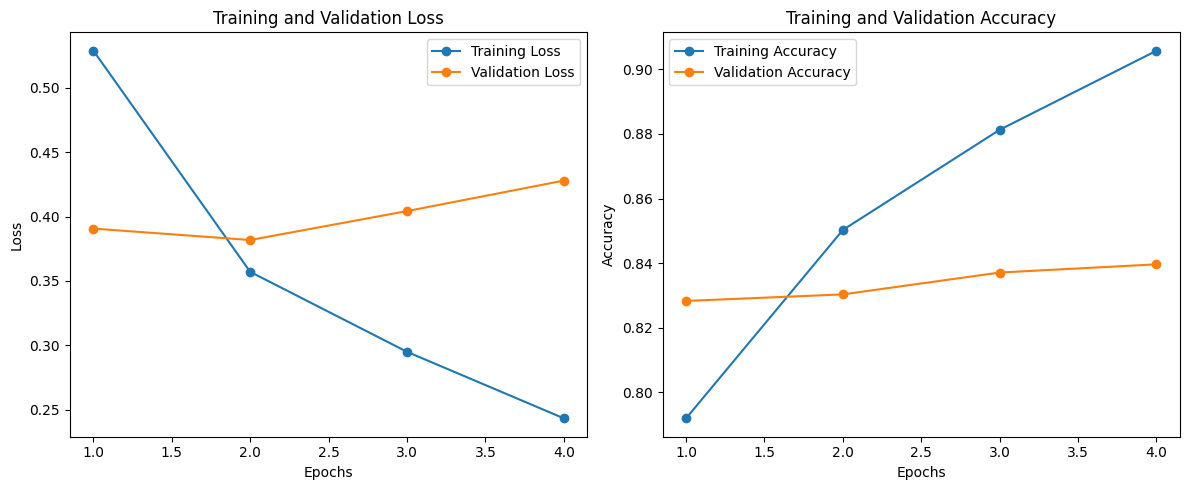

In [19]:
import matplotlib.pyplot as plt

# Extract metrics from model history
history = model_history.history
epochs = range(1, len(history['loss']) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph (if available)
if 'accuracy' in history:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 310, 100)       │     6,397,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 200)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu (Dense)                    │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,797,005 (75.52 MB)

 Trainable params: 6,599,001 (25.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,198,004 (50.35 MB)

## Summary

In [20]:
y_pred = model.predict(X_test_tensor)
y_pred = [0 if pred < 0.5 else 1 for pred in y_pred]

800/800 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     12800
           1       0.85      0.81      0.83     12800

    accuracy                           0.84     25600
   macro avg       0.84      0.84      0.84     25600
weighted avg       0.84      0.84      0.84     25600



In [23]:
model.save('model.keras')